In [1]:
import pandas as pd 
import numpy as np
import ast 
import matplotlib.pyplot as plt 
import glob
import re 

BUCKET = 'd3-ai-orion'
S3_URL = 'https://{}.s3.amazonaws.com/{}'

BENCHMARK_DATA = pd.read_csv(S3_URL.format(
    BUCKET, 'datasets.csv'), index_col=0, header=None).applymap(ast.literal_eval).to_dict()[1]

# Load datasets 

## mSSA


In [2]:
df_mssa_scores = pd.read_pickle("mssa_scores.pkl").query("mssa_rank == 2")
df_mssa_summary = pd.read_pickle("mssa_summaries.pkl").query("mssa_rank == 2")

In [3]:
df_optmssa_scores = pd.read_pickle("mssa_scores.pkl").sort_values("f1", ascending=False).drop_duplicates("signal", keep="first")
df_optmssa_summary = pd.read_pickle("mssa_summaries.pkl").sort_values("f1", ascending=False).drop_duplicates("dataset", keep="first")

df_optmssa_scores['pipeline'] = "mssa_opt"
df_optmssa_summary['pipeline'] = "mssa_opt"

In [ ]:
# df_mssa_summary.groupby("mssa_rank")['f1'].agg([np.mean, np.std])

In [ ]:
pd.read_pickle("mssa_summaries.pkl").query("dataset=='YAHOOA3'").sort_values("f1", ascending=False)

## Prophet 

In [4]:
df_prophet_scores = pd.read_csv("prophet_deepar_results/final/scores_prophet.csv")
df_prophet_summary = pd.read_csv("prophet_deepar_results/final/summary_prophet.csv")

## DeepAR 

In [5]:
df_deepar_scores = pd.read_csv("prophet_deepar_results/final/scores_deepar.csv")
df_deepar_summary = pd.read_csv("prophet_deepar_results/final/summary_deepar.csv")

## Orbit 

In [6]:
df_orbit_scores = pd.concat([pd.read_pickle("yahoo_results/orbit_scores_flat.pkl"),
                             pd.read_pickle("numenta_results/orbit_scores_flat.pkl"),
                             pd.read_pickle("nasa_results/orbit_scores_split_flat.pkl")], ignore_index = True)


df_orbit_summary = pd.concat([pd.read_pickle("yahoo_results/orbit_summaries_flat.pkl"),
                             pd.read_pickle("numenta_results/orbit_summaries_flat.pkl"),
                             pd.read_pickle("nasa_results/orbit_summaries_split_flat.pkl")], ignore_index = True)

# Sanity checks 

In [7]:
#number of summaries 
for df in [df_optmssa_summary, df_mssa_summary, df_prophet_summary, df_deepar_summary, df_orbit_summary]:
    print(len(df))


print("\n\n")

#number of errors in scores 
for df in [df_optmssa_scores, df_mssa_scores, df_prophet_scores, df_deepar_scores, df_orbit_scores]:
    print(len(df))
    print(df.status.value_counts())

    

11
11
11
11
11



492
0    492
Name: status, dtype: int64
492
0    492
Name: status, dtype: int64
492
0    492
Name: status, dtype: int64
492
0    492
Name: status, dtype: int64
492
0    472
1     20
Name: status, dtype: int64


# Analyses 

## Scores and durations

In [8]:
pd.concat([df_optmssa_summary, df_mssa_summary, df_prophet_summary, df_deepar_summary, df_orbit_summary], ignore_index=True).loc[:,:"f1"].pivot(index="pipeline", columns="dataset", values="f1").round(2)

dataset,MSL,SMAP,YAHOOA1,YAHOOA2,YAHOOA3,YAHOOA4,artificialWithAnomaly,realAWSCloudwatch,realAdExchange,realTraffic,realTweets
pipeline,,,,,,,,,,,
deepar,0.39,0.48,0.65,0.97,0.67,0.52,0.80,0.44,0.48,0.57,0.55
mssa,0.39,0.23,0.69,0.89,0.96,0.69,0.26,0.33,0.53,0.52,0.15
mssa_opt,0.48,0.43,0.75,0.93,1.00,0.90,0.36,0.33,0.59,0.52,0.15
orbit,0.34,0.28,0.81,0.98,1.00,0.87,0.10,0.32,0.53,0.63,0.15
prophet,0.39,0.41,0.54,0.82,0.33,0.17,0.60,0.60,0.47,0.53,0.53


In [9]:
pd.DataFrame(pd.concat([df_optmssa_scores, df_mssa_scores, df_prophet_scores, df_deepar_scores, df_orbit_scores], 
                       ignore_index=True).groupby(['pipeline','dataset'])['elapsed'].agg(np.median).round(2)).reset_index().pivot(index="pipeline", columns="dataset", values="elapsed")

dataset,MSL,SMAP,YAHOOA1,YAHOOA2,YAHOOA3,YAHOOA4,artificialWithAnomaly,realAWSCloudwatch,realAdExchange,realTraffic,realTweets
pipeline,,,,,,,,,,,
deepar,267.20,469.50,209.03,216.40,250.86,183.92,271.25,325.97,968.17,399.45,517.01
mssa,0.13,0.29,0.12,0.12,0.12,0.12,0.24,0.21,0.11,0.13,0.61
mssa_opt,0.13,0.30,0.12,0.12,0.12,0.12,0.19,0.20,0.12,0.13,0.62
orbit,20.59,25.89,10.11,9.08,10.72,10.70,19.37,30.63,9.79,13.11,232.25
prophet,222.91,412.51,6.96,11.65,16.73,16.12,227.93,176.53,1146.15,213.28,788.63


## mssa scores with changing rank 

Text(0, 0.5, 'F1 Score')

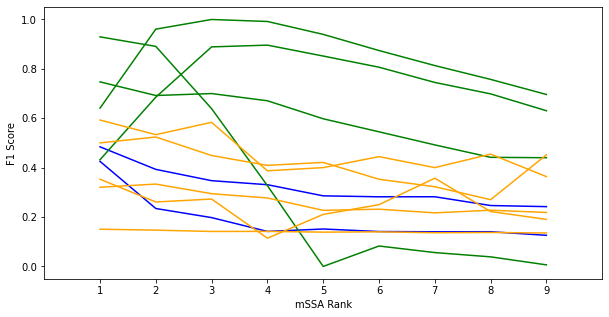

In [10]:
df_allmssa_summaries = pd.read_pickle("mssa_summaries.pkl")

plt.figure(figsize=(10,5))
for dataset in BENCHMARK_DATA.keys():
#     plt.figure()
#     plt.scatter([-1],df_allmssa_summaries.query("dataset == @dataset").f1.values[0])
#     plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:])

    if dataset in {"SMAP", "MSL"}:
        plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:], c="blue", label="NASA")
    elif "YAHOO" in dataset:
        plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:], c="green", label="Yahoo")
    else:
        plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:], c="orange", label="Numenta")
    
#     plt.title(dataset)

# plt.legend()
plt.xlim(0,10)
plt.xticks(list(range(1,10)))
plt.ylim(-0.05,1.05)
plt.xlabel("mSSA Rank")
plt.ylabel("F1 Score")

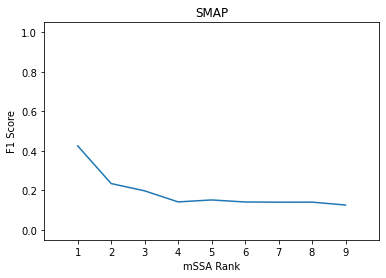

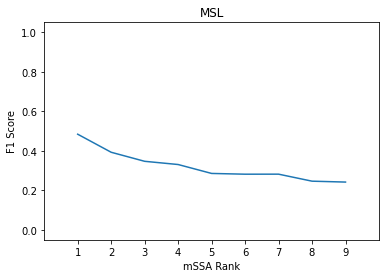

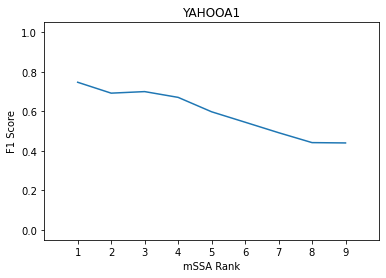

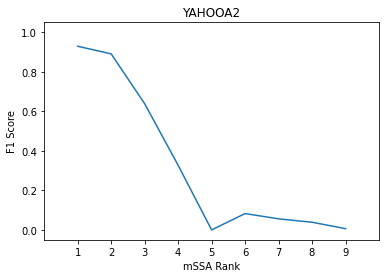

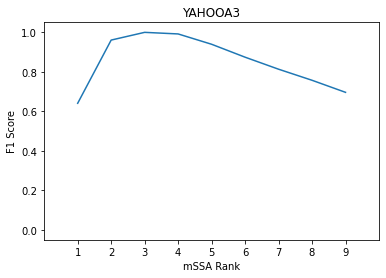

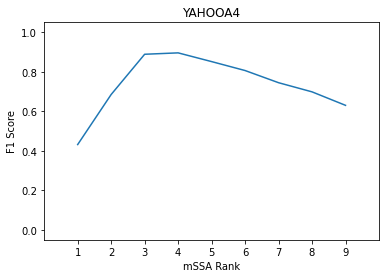

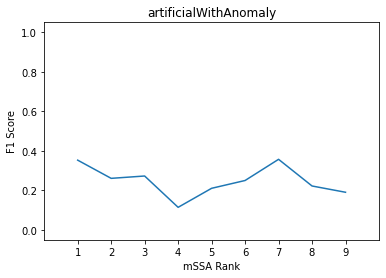

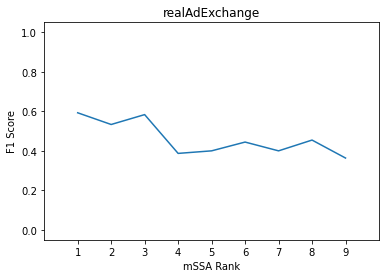

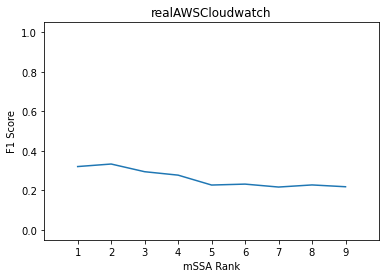

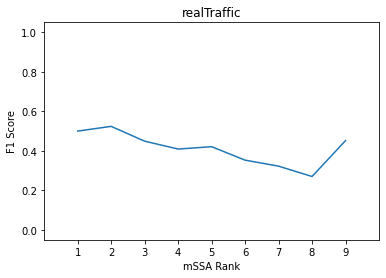

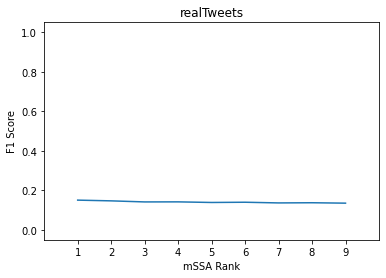

In [11]:
for dataset in BENCHMARK_DATA.keys():
    plt.figure()
#     plt.scatter([-1],df_allmssa_summaries.query("dataset == @dataset").f1.values[0])
    plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:])
    plt.title(dataset)
    plt.xlabel("mSSA Rank")
    plt.ylabel("F1 Score")
    plt.xlim(0,10)
    plt.xticks(list(range(1,10)))
    plt.ylim(-0.05,1.05)

## Dataset spectral analysis 

In [13]:
#for nasa, calculating spectra on train data  
filepaths = [x for x in glob.glob("./Orion/orion/data/**", recursive=True) if x.endswith(".csv") and "_all" not in x and "-test" not in x]

In [17]:
df_optmssa_spectra = df_optmssa_scores.copy()
spectra_dict = {}



for filepath in filepaths: 
    try:
        signal_name = filepath.split("/")[-1][:-4]
        signal_name = re.sub("-train", "", signal_name)

        temp_df = pd.read_csv(filepath)
        m_dim = int(np.sqrt(len(temp_df)))
        n_dim = len(temp_df)//m_dim
        m = np.reshape(temp_df.value.values[:m_dim*n_dim], (m_dim,n_dim))
        m = m - m.mean()

        u,s,_ = np.linalg.svd(m)
        # s = s/s[0]
        S = np.cumsum(s**2)
        S = S/S[-1]

#         df_optmssa_spectra.loc[df_optmssa_spectra['signal'] == signal_name, "energy"] = str(S)
        spectra_dict[signal_name] = S
    
    except:
        print(filepath)

<ipython-input-17-e9062da0ab9c>:20: RuntimeWarning: invalid value encountered in true_divide
  S = S/S[-1]


./Orion/orion/data/anomalies.csv


In [18]:
df_optmssa_spectra['energy'] = df_optmssa_spectra['signal'].map(spectra_dict)

In [19]:
#get energy at optimimum level
df_optmssa_spectra.loc[(~df_optmssa_spectra['energy'].isnull()) & (~df_optmssa_spectra['mssa_rank'].isnull()), "optimal_energy_level"] = df_optmssa_spectra[~df_optmssa_spectra['energy'].isnull()][~df_optmssa_spectra['mssa_rank'].isnull()].apply(lambda x: x.energy[int(x.mssa_rank)], axis=1)

In [ ]:
sv_index = 2
dataset = "YAHOOA1"
energy_levels = [x[sv_index] for x in df_optmssa_spectra.query("dataset == @dataset")['energy']]
# opt_energy_levels = 
f1_scores = df_optmssa_spectra.query("dataset == @dataset").f1.values

plt.scatter(energy_levels, f1_scores)
plt.ylim()

In [ ]:
plt.scatter(df_optmssa_spectra.query("dataset == 'YAHOOA1'")['optimal_energy_level'], df_optmssa_spectra.query("dataset == 'YAHOOA1'")['f1'])

In [ ]:
sv_index = 1
dataset = "realAWSCloudwatch"
energy_levels = [x[sv_index] for x in df_optmssa_spectra.query("dataset == @dataset")['energy']]
# opt_energy_levels = 
f1_scores = df_optmssa_spectra.query("dataset == @dataset").f1.values

plt.scatter(energy_levels, f1_scores)
plt.ylim()

In [ ]:
plt.scatter(df_optmssa_spectra.query("dataset == 'realAWSCloudwatch'")['optimal_energy_level'], df_optmssa_spectra.query("dataset == 'realAWSCloudwatch'")['f1'])

In [ ]:
#Caveat: we don't have rank for when "None" is best 

for dataset in df_optmssa_spectra.dataset.unique():
    try:
        plt.figure()
        plt.scatter(df_optmssa_spectra.query("dataset == @dataset")['optimal_energy_level'], df_optmssa_spectra.query("dataset == @dataset")['f1'])
        plt.title(dataset)
        plt.xlabel("energy at optimal rank")
        plt.ylabel("f1 score")
        plt.ylim(-0.05,1.05)
        plt.xlim(-0.05,1.05)
    except:
        print(dataset)

## Color spectra by accuracy 

In [26]:
import matplotlib
import matplotlib.cm as cm

In [35]:
norm = matplotlib.colors.Normalize(vmin=df_optmssa_spectra.f1.min(), vmax=df_optmssa_spectra.f1.max(), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

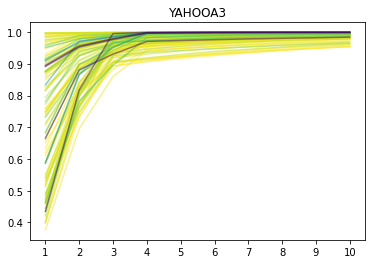

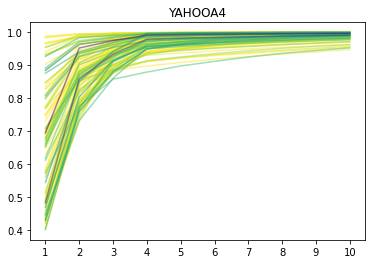

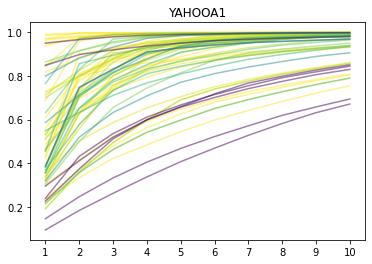

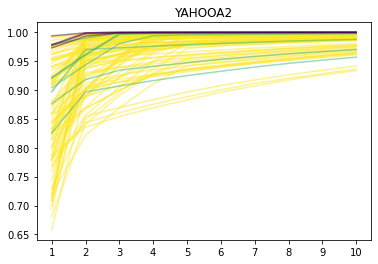

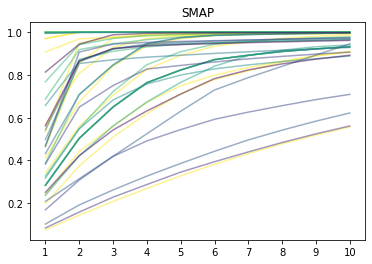

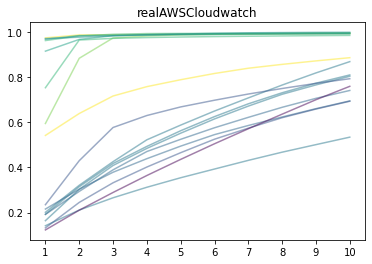

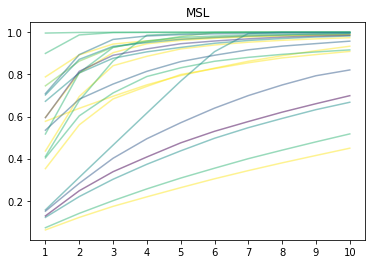

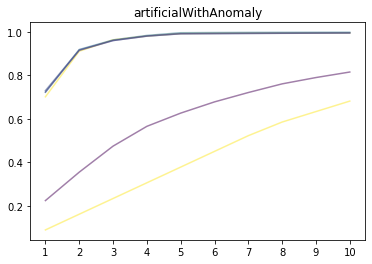

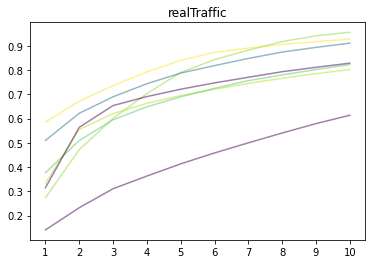

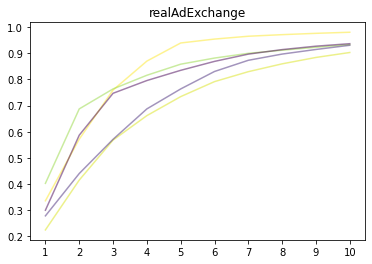

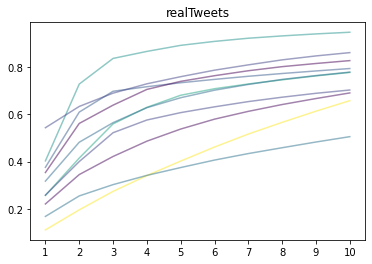

In [38]:
for dataset in df_optmssa_spectra.dataset.unique():
    plt.figure()
    norm = matplotlib.colors.Normalize(vmin=df_optmssa_spectra.query("dataset == @dataset").f1.min(), vmax=df_optmssa_spectra.query("dataset == @dataset").f1.max(), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
    
    for row in df_optmssa_spectra.query("dataset == @dataset").itertuples():
        plt.plot(range(1,11), row.energy[:10], c=mapper.to_rgba(row.f1), alpha=0.5)
#     for spectrum in df_optmssa_spectra.query("dataset == @dataset").energy.values:
#             plt.plot(range(1,11), spectrum[:10], color="blue", alpha=0.2)
    
    
    plt.xticks(range(1,11))
    plt.title(dataset)

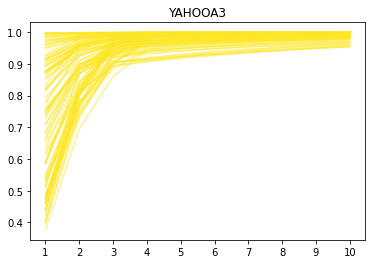

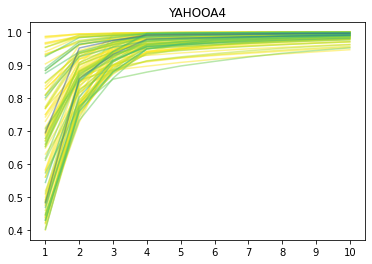

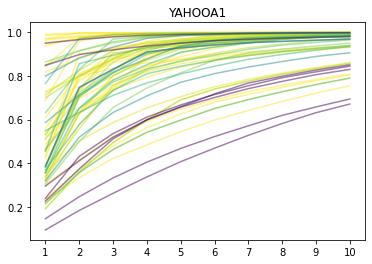

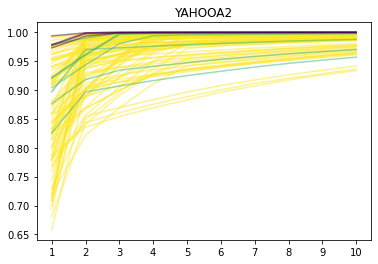

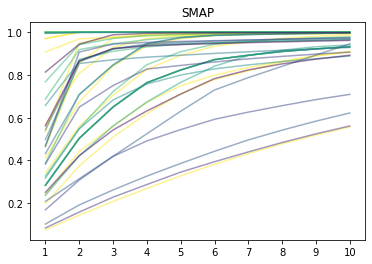

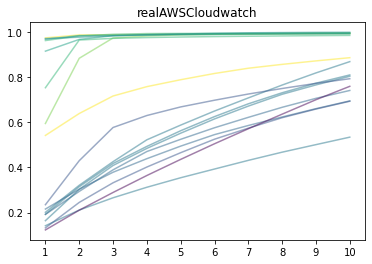

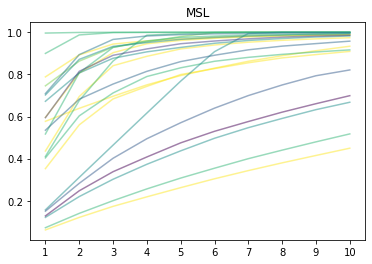

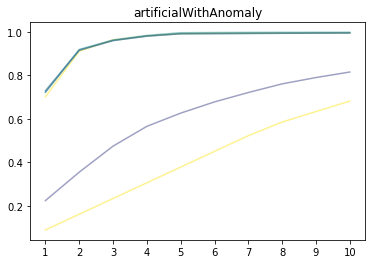

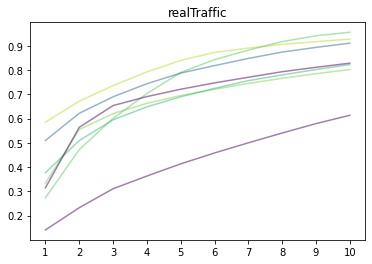

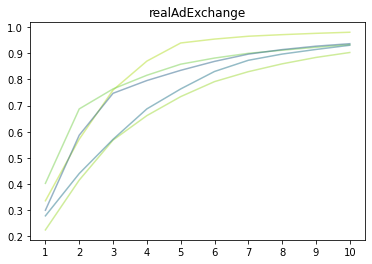

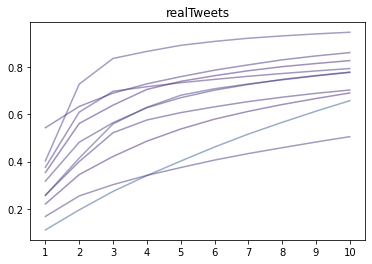

In [37]:
for dataset in df_optmssa_spectra.dataset.unique():
    plt.figure()
    
    
    for row in df_optmssa_spectra.query("dataset == @dataset").itertuples():
        plt.plot(range(1,11), row.energy[:10], c=mapper.to_rgba(row.f1), alpha=0.5)
#     for spectrum in df_optmssa_spectra.query("dataset == @dataset").energy.values:
#             plt.plot(range(1,11), spectrum[:10], color="blue", alpha=0.2)
    
    
    plt.xticks(range(1,11))
    plt.title(dataset)

In [ ]:
for dataset in df_optmssa_spectra.dataset.unique():    
    
    for row in df_optmssa_spectra.query("dataset == @dataset").itertuples():
        plt.plot(range(1,11), row.energy[:10], c=mapper.to_rgba(row.f1), alpha=0.5)
#     for spectrum in df_optmssa_spectra.query("dataset == @dataset").energy.values:
#             plt.plot(range(1,11), spectrum[:10], color="blue", alpha=0.2)
    
    
    plt.xticks(range(1,11))
    plt.title(dataset)

In [49]:
df_optmssa_spectra['energy_top10'] = [x[:10] for x in df_optmssa_spectra['energy']]

In [56]:
df_optmssa_spectra.query("dataset=='SMAP'")

,pipeline,rank,f1,recall,precision,confusion_matrix,status,elapsed,split,dataset,signal,mssa_rank,fp,fn,tp,energy,optimal_energy_level,energy_top10
36,mssa_opt,37,1.000000,1.000000,1.000000,"(0, 0, 3)",0,0.278107,True,SMAP,P-4,None,0,0,3,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
575,mssa_opt,84,1.000000,1.000000,1.000000,"(0, 0, 2)",0,0.264041,True,SMAP,T-3,1,0,0,2,"[0.5332839145099065, 0.9499338240053729, 0.977...",0.949934,"[0.5332839145099065, 0.9499338240053729, 0.977..."
606,mssa_opt,115,1.000000,1.000000,1.000000,"(0, 0, 1)",0,0.291049,True,SMAP,E-9,1,0,0,1,"[0.5674893692120957, 0.8081380052104205, 0.928...",0.808138,"[0.5674893692120957, 0.8081380052104205, 0.928..."
610,mssa_opt,119,1.000000,1.000000,1.000000,"(0, 0, 1)",0,0.267969,True,SMAP,D-2,1,0,0,1,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
602,mssa_opt,111,1.000000,1.000000,1.000000,"(0, 0, 1)",0,0.332487,True,SMAP,E-5,1,0,0,1,"[0.28348427665895537, 0.5033459305129642, 0.64...",0.503346,"[0.28348427665895537, 0.5033459305129642, 0.64..."
603,mssa_opt,112,1.000000,1.000000,1.000000,"(0, 0, 1)",0,0.285069,True,SMAP,E-6,1,0,0,1,"[0.1975191470528433, 0.3741038784252098, 0.509...",0.374104,"[0.1975191470528433, 0.3741038784252098, 0.509..."
578,mssa_opt,87,1.000000,1.000000,1.000000,"(0, 0, 1)",0,0.279121,True,SMAP,D-12,1,0,0,1,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
583,mssa_opt,92,1.000000,1.000000,1.000000,"(0, 0, 1)",0,0.202047,True,SMAP,A-5,1,0,0,1,"[0.46552830098292736, 0.8548580174985521, 0.97...",0.854858,"[0.46552830098292736, 0.8548580174985521, 0.97..."
584,mssa_opt,93,1.000000,1.000000,1.000000,"(0, 0, 1)",0,0.222127,True,SMAP,A-6,1,0,0,1,"[0.9074136368526339, 0.9690296501905784, 0.976...",0.969030,"[0.9074136368526339, 0.9690296501905784, 0.976..."
585,mssa_opt,94,1.000000,1.000000,1.000000,"(0, 0, 1)",0,0.299143,True,SMAP,A-7,1,0,0,1,"[0.23943533240110582, 0.44211270628336985, 0.5...",0.442113,"[0.23943533240110582, 0.44211270628336985, 0.5..."


In [57]:
spectra_means = df_optmssa_spectra.dropna(subset=["optimal_energy_level"]).groupby("dataset")['energy_top10'].apply(np.mean)

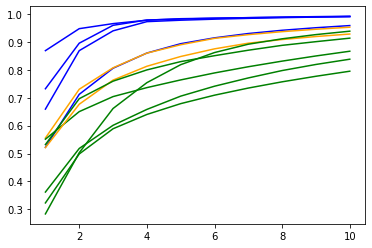

In [60]:
for dataset in df_optmssa_spectra.dataset.unique(): 
    if dataset in {"SMAP", "MSL"}:
        plt.plot(range(1,11), spectra_means[dataset], c="orange", label="NASA")
    elif "YAHOO" in dataset:
        plt.plot(range(1,11), spectra_means[dataset], c="blue", label="YAHOO")
    else:
        plt.plot(range(1,11), spectra_means[dataset], c="green", label="NAB")
    
    

In [62]:
list(zip(spectra_means.index, [x[-1] for x in spectra_means]))

[('MSL', 0.927945608012387),
 ('SMAP', 0.9523452205133862),
 ('YAHOOA1', 0.9582156220945053),
 ('YAHOOA2', 0.9904204048919),
 ('YAHOOA3', 0.9916320696157921),
 ('YAHOOA4', 0.9903156291472338),
 ('artificialWithAnomaly', 0.9131743029079492),
 ('realAWSCloudwatch', 0.8663907148558823),
 ('realAdExchange', 0.9381172910763684),
 ('realTraffic', 0.8378340507612164),
 ('realTweets', 0.7948361362259005)]

In [ ]:
MSL	SMAP	YAHOOA1	YAHOOA2	YAHOOA3	YAHOOA4	artificialWithAnomaly	realAWSCloudwatch	realAdExchange	realTraffic	realTweets